## 1. Imports


In [1]:
import sys
import gc
import os

import torch
from torch.utils.data import Subset
import torchvision.datasets as datasets
import numpy as np
from diffusers import DDIMScheduler
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

sys.path.append("..")
from utils import (
    set_random_seed,
    get_ddim_path,
    cod_prob_bound,
)

%matplotlib inline 

## 2. Config


In [2]:
SEED = 0x4090
set_random_seed(SEED)

# dataset choosing
# DATASET, DATASET_PATH = "fmnist", "./data/"
# DATASET, DATASET_PATH = "usps", "./data/"
DATASET, DATASET_PATH = "mnist", "./data/"

IMG_SIZE = 28

# the step number adding noise in diffusion process
DIFFUSION_STEPS = 100
SCHEDULER = DDIMScheduler(num_train_timesteps=DIFFUSION_STEPS)
PIVOTAL_LIST = None
# PIVOTAL_LIST = [20, 50, 100]

# All hyperparameters below is set to the values used for the experiments, which discribed in the article
EPSILON = 0.1
# R = 1000
N = 2
P = 1
NUM_QUERY = 10
MAX_NUM_SAMPLE = 1000

# plot settings
GRAY_PLOTS = True

## 3. Initialize dataset


In [3]:
transform = Compose(
    [
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize((0.5), (0.5)),
    ]
)

if DATASET == "fmnist":
    source = datasets.FashionMNIST(
        root=DATASET_PATH, train=True, download=True, transform=transform
    )
elif DATASET == "usps":
    source = datasets.USPS(
        root=os.path.join(DATASET_PATH, "USPS/raw"),
        train=True,
        download=True,
        transform=transform,
    )
elif DATASET == "mnist":
    source = datasets.MNIST(
        root=DATASET_PATH, train=True, download=True, transform=transform
    )
else:
    raise "Invalid dataset name"

In [4]:
source_indices = np.random.choice(
    len(source), min(MAX_NUM_SAMPLE, len(source)), replace=False
)
source_dataset = Subset(source, source_indices)
len(source_dataset)

1000

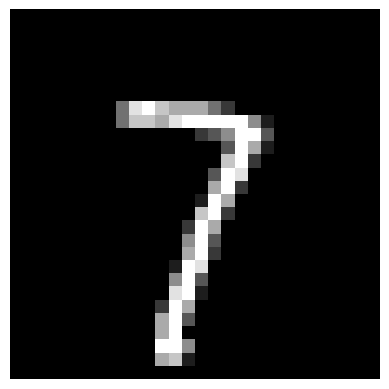

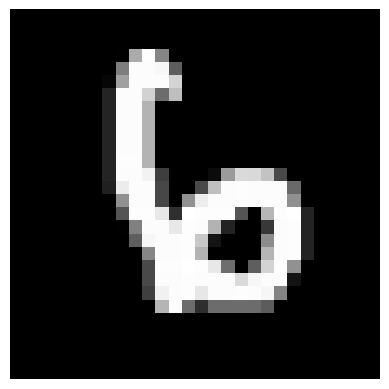

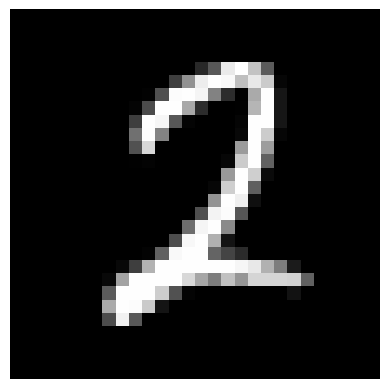

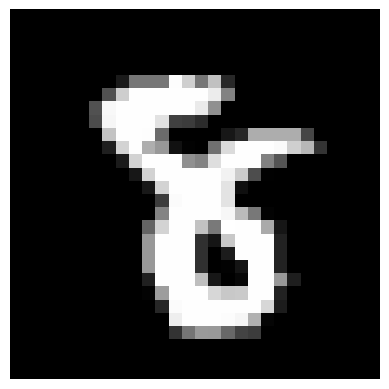

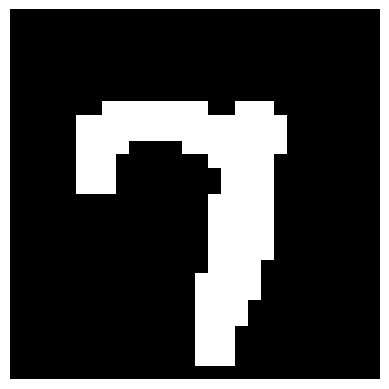

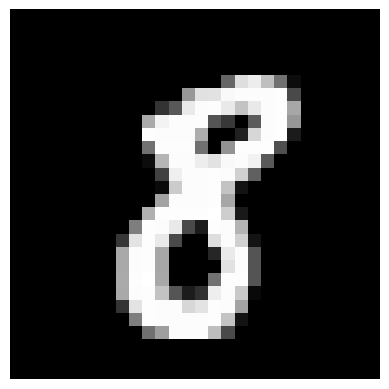

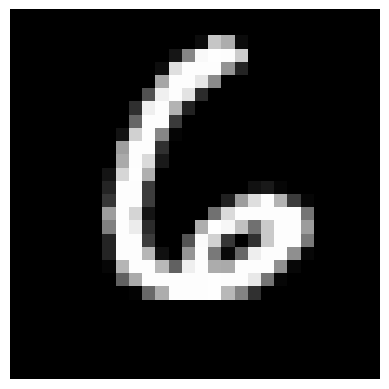

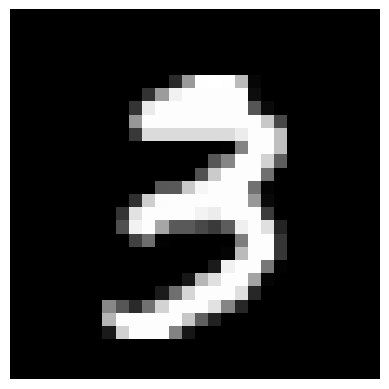

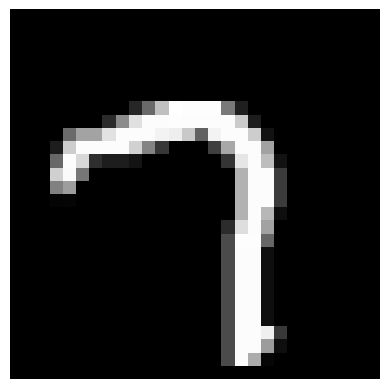

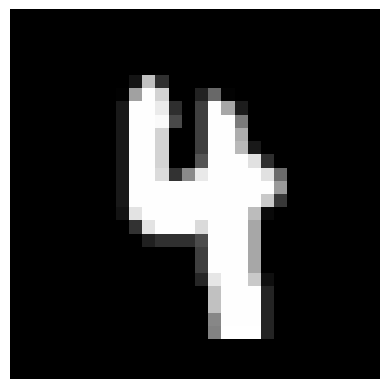

In [5]:
def plot_data_point(x):
    plt.imshow(x.squeeze().numpy(), cmap="gray")
    plt.axis("off")  # 不显示坐标轴
    plt.show()


for _ in range(10):
    plot_data_point(source_dataset[np.random.randint(0, len(source_dataset))][0])

In [6]:
from typing import Union


def plot_path(
    path: Union[list, torch.Tensor],
    indices: list = None,
    gray: bool = False,
):
    if indices is not None:
        path = [path[i] for i in indices]
    if isinstance(path, list):
        path = torch.stack(path)

    imgs: np.ndarray = (
        path.to("cpu").permute(0, 2, 3, 1).mul(0.5).add(0.5).numpy().clip(0, 1)
    )

    if len(path) < 10:
        ncols = len(path)
        nrows = 1
    else:
        ncols = 10
        nrows = len(path) // 10 + 1

    fig = plt.figure(figsize=(1.5 * ncols, 1.5 * nrows), dpi=150)
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        if gray:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"$X_{{{i}}}$", fontsize=16)
        if i == imgs.shape[0] - 1:
            ax.set_title("Y", fontsize=16)
    fig.tight_layout()
    torch.cuda.empty_cache()
    gc.collect()

## 4. Concentration of Distance Probability


#### X2G: generate asymptotic distribution


In [7]:
image_shape = (1, IMG_SIZE, IMG_SIZE) if GRAY_PLOTS else (3, IMG_SIZE, IMG_SIZE)

x2g_asymptotic_dataset = torch.empty(
    (DIFFUSION_STEPS + 1, len(source_dataset), *image_shape), dtype=torch.float32
)

In [8]:
for i, (x, _) in enumerate(tqdm(source_dataset)):
    path = get_ddim_path(x, SCHEDULER, reverse=False)
    x2g_asymptotic_dataset[:, i] = path

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
x2g_asymptotic_dataset.shape

torch.Size([101, 1000, 1, 28, 28])

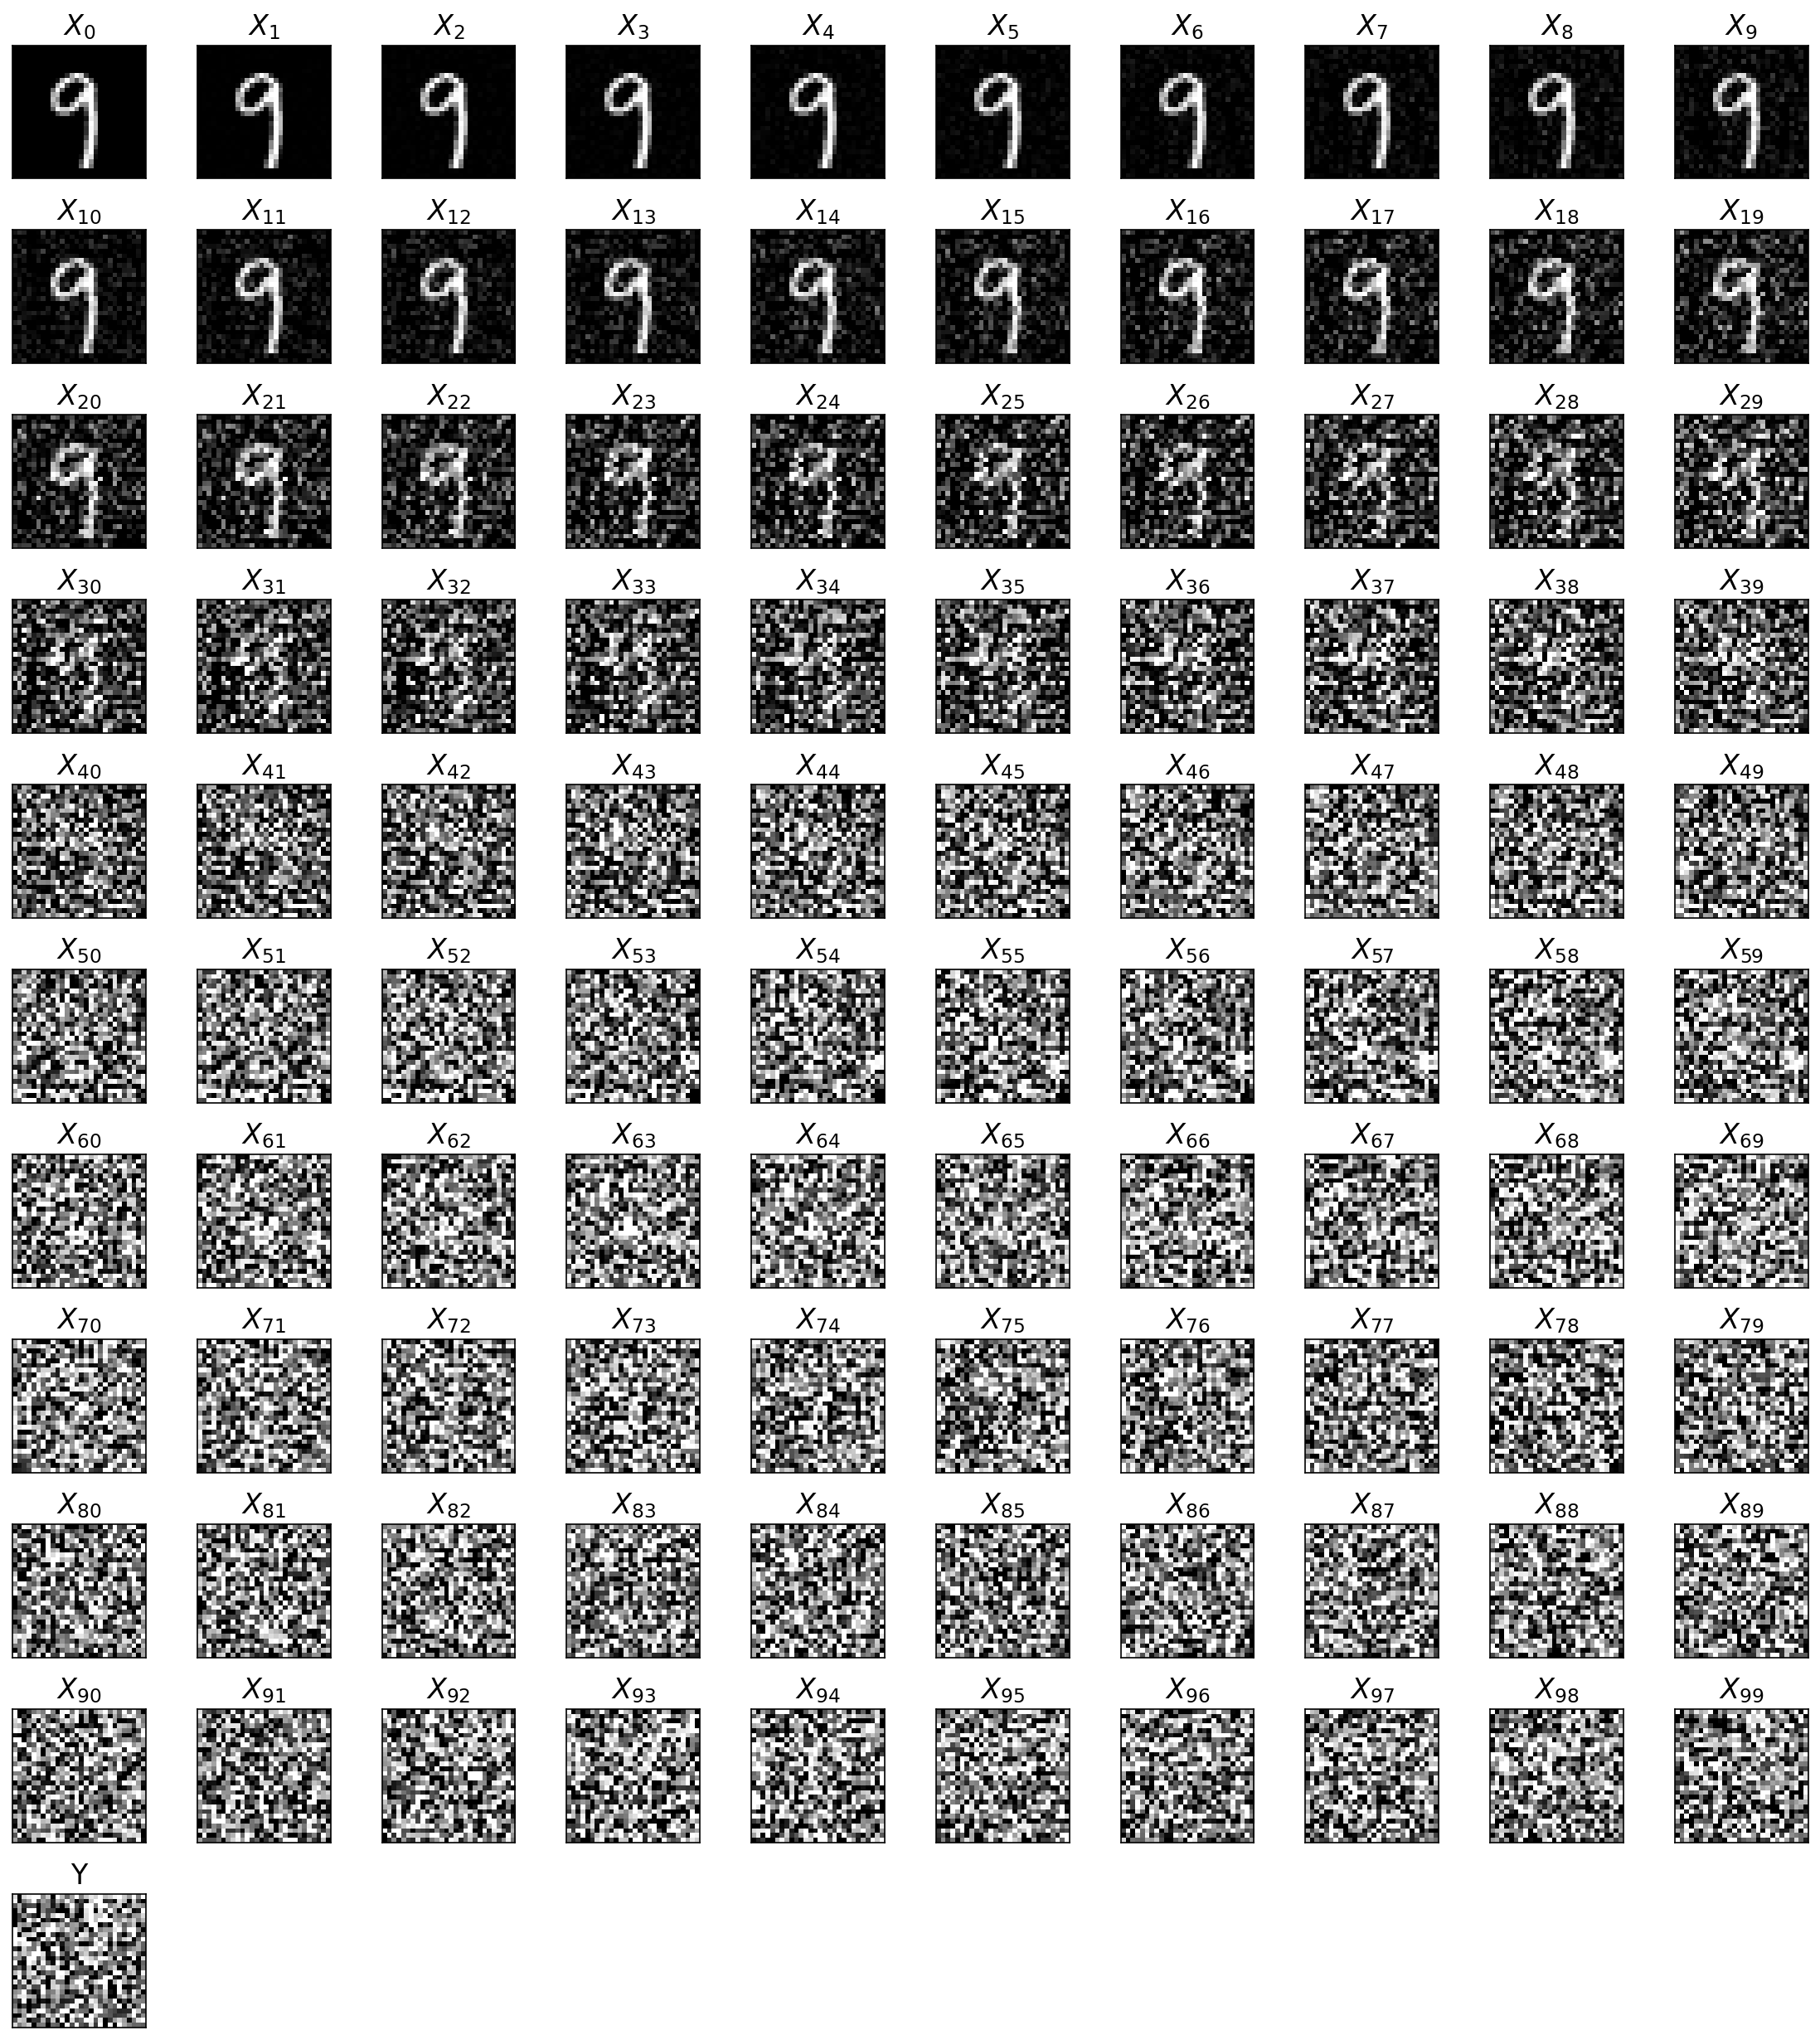

In [10]:
plot_path(
    x2g_asymptotic_dataset[:, 0],
    # indices=PIVOTAL_LIST,
    gray=GRAY_PLOTS,
)

#### X2G: caculate CoD Prob Bound


In [12]:
Q_point_indices = np.random.choice(
    x2g_asymptotic_dataset.shape[1], NUM_QUERY, replace=False
)
Q_point_dataset = x2g_asymptotic_dataset[0][Q_point_indices]
T_point_dataset = x2g_asymptotic_dataset[-1]

prob_bound_list = []
for Q_point in Q_point_dataset:
    prob_bound = cod_prob_bound(
        T_point_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
x2g_ddim_prob_bound = prob_bound_list.mean()

print(
    f"t={0} -> t={x2g_asymptotic_dataset.shape[0]-1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={x2g_ddim_prob_bound:.4%}"
)

t=0 -> t=100: P{DMAX(2)<=(1+0.1)DMIN(2)}>=62.5828%


In [13]:
x2g_ddim_prob_bound_list = []
for t in range(x2g_asymptotic_dataset.shape[0] - 1):
    Q_point_dataset = x2g_asymptotic_dataset[t][Q_point_indices]
    T_point_dataset = x2g_asymptotic_dataset[t + 1]

    # plot_data_point(Q_point)
    prob_bound_list = []
    for Q_point in Q_point_dataset:
        prob_bound = cod_prob_bound(
            T_point_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
        prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    print(f"t={t} -> t={t+1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

    x2g_ddim_prob_bound_list.append(prob_bound)

t=0 -> t=1: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=1 -> t=2: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=2 -> t=3: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=3 -> t=4: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=4 -> t=5: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=5 -> t=6: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=6 -> t=7: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=7 -> t=8: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=8 -> t=9: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=9 -> t=10: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=10 -> t=11: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=11 -> t=12: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=12 -> t=13: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=13 -> t=14: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=14 -> t=15: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=15 -> t=16: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=16 -> t=17: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=17 -> t=18: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=18 -> t=19: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=19 -> t=20: P{DMAX(2)<=(1+0.1)DMIN(2)}>=0.0000%
t=20 -> t=21: P{DMA

#### G2X: generate asymptotic distribution


In [14]:
g2x_asymptotic_dataset = torch.flip(x2g_asymptotic_dataset, [0])

#### G2X: caculate CoD Prob Bound


In [15]:
Q_point_indices = np.random.choice(
    g2x_asymptotic_dataset.shape[1], NUM_QUERY, replace=False
)
Q_point_dataset = g2x_asymptotic_dataset[0][Q_point_indices]
T_point_dataset = g2x_asymptotic_dataset[-1]

prob_bound_list = []
for Q_point in Q_point_dataset:
    prob_bound = cod_prob_bound(
        T_point_dataset,
        EPSILON,
        Q_point,
        "euclidean",
        N,
    )
    prob_bound_list.append(prob_bound)
prob_bound_list = np.array(prob_bound_list)
g2y_ddim_prob_bound = prob_bound_list.mean()

print(
    f"t={0} -> t={g2x_asymptotic_dataset.shape[0]-1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={g2y_ddim_prob_bound:.4%}"
)

t=0 -> t=100: P{DMAX(2)<=(1+0.1)DMIN(2)}>=91.2270%


In [16]:
g2y_ddim_prob_bound_list = []
for t in range(g2x_asymptotic_dataset.shape[0] - 1):
    Q_point_dataset = g2x_asymptotic_dataset[t][Q_point_indices]
    T_point_dataset = g2x_asymptotic_dataset[t + 1]

    # plot_data_point(Q_point)
    prob_bound_list = []
    for Q_point in Q_point_dataset:
        prob_bound = cod_prob_bound(
            T_point_dataset,
            EPSILON,
            Q_point,
            "euclidean",
            N,
        )
        prob_bound_list.append(prob_bound)
    prob_bound_list = np.array(prob_bound_list)
    prob_bound = prob_bound_list.mean()
    print(f"t={t} -> t={t+1}: P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}>={prob_bound:.4%}")

    g2y_ddim_prob_bound_list.append(prob_bound)

t=0 -> t=1: P{DMAX(2)<=(1+0.1)DMIN(2)}>=54.2153%
t=1 -> t=2: P{DMAX(2)<=(1+0.1)DMIN(2)}>=53.3371%
t=2 -> t=3: P{DMAX(2)<=(1+0.1)DMIN(2)}>=52.6591%
t=3 -> t=4: P{DMAX(2)<=(1+0.1)DMIN(2)}>=51.4862%
t=4 -> t=5: P{DMAX(2)<=(1+0.1)DMIN(2)}>=51.7148%
t=5 -> t=6: P{DMAX(2)<=(1+0.1)DMIN(2)}>=51.6642%
t=6 -> t=7: P{DMAX(2)<=(1+0.1)DMIN(2)}>=51.5343%
t=7 -> t=8: P{DMAX(2)<=(1+0.1)DMIN(2)}>=51.5895%
t=8 -> t=9: P{DMAX(2)<=(1+0.1)DMIN(2)}>=50.1336%
t=9 -> t=10: P{DMAX(2)<=(1+0.1)DMIN(2)}>=50.3897%
t=10 -> t=11: P{DMAX(2)<=(1+0.1)DMIN(2)}>=50.1770%
t=11 -> t=12: P{DMAX(2)<=(1+0.1)DMIN(2)}>=50.5765%
t=12 -> t=13: P{DMAX(2)<=(1+0.1)DMIN(2)}>=50.1606%
t=13 -> t=14: P{DMAX(2)<=(1+0.1)DMIN(2)}>=49.4798%
t=14 -> t=15: P{DMAX(2)<=(1+0.1)DMIN(2)}>=48.9655%
t=15 -> t=16: P{DMAX(2)<=(1+0.1)DMIN(2)}>=49.1898%
t=16 -> t=17: P{DMAX(2)<=(1+0.1)DMIN(2)}>=47.9059%
t=17 -> t=18: P{DMAX(2)<=(1+0.1)DMIN(2)}>=48.2546%
t=18 -> t=19: P{DMAX(2)<=(1+0.1)DMIN(2)}>=46.6125%
t=19 -> t=20: P{DMAX(2)<=(1+0.1)DMIN(2)}>=47.8057%

In [17]:
len(g2y_ddim_prob_bound_list)

100

## Plot


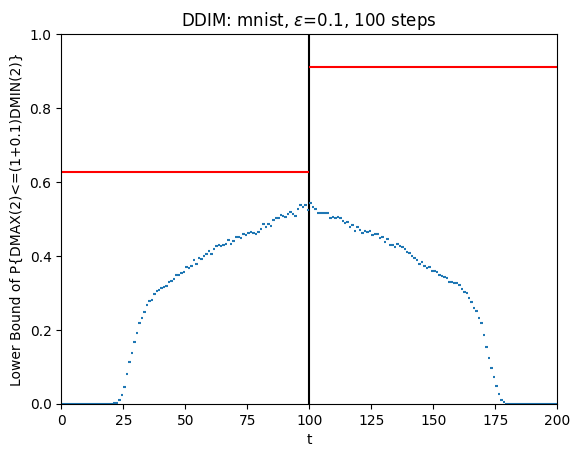

In [18]:
plt.vlines(DIFFUSION_STEPS, 0, 1, colors="black")

plt.hlines(x2g_ddim_prob_bound, 0, DIFFUSION_STEPS, colors="red")
plt.hlines(g2y_ddim_prob_bound, DIFFUSION_STEPS, DIFFUSION_STEPS * 2, colors="red")

for t, prob in enumerate(x2g_ddim_prob_bound_list):
    plt.hlines(prob, t, t + 1)
for t, prob in enumerate(g2y_ddim_prob_bound_list):
    plt.hlines(prob, DIFFUSION_STEPS + t, DIFFUSION_STEPS + t + 1)

plt.xlabel("t")
plt.ylabel(f"Lower Bound of P{{DMAX({N})<=(1+{EPSILON})DMIN({N})}}")

plt.xlim(0, DIFFUSION_STEPS * 2)
plt.ylim(0, 1)
plt.margins(x=0)
plt.title(f"DDIM: {DATASET}, $\epsilon$={EPSILON}, {DIFFUSION_STEPS} steps")
plt.show()